In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import joblib

In [2]:
sns.set(style="whitegrid")

In [3]:

def create_fts(df):
    df = df.copy()
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 20, 30, 40, 50, 60, 100],
                            labels=['0-20', '21-30', '31-40', '41-50', '51-60', '60+'])
    df['balance_group'] = pd.qcut(df['balance'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
    df['campaign_intensity'] = df['campaign'] / (df['pdays'].replace(-1, 999) + 1)
    df['campaign_intensity'] = df['campaign_intensity'].clip(upper=df['campaign_intensity'].quantile(0.99))
    
    df['contact_rate'] = df['previous'] / (df['pdays'].replace(-1, 999) + 1)
    df['contact_rate'] = df['contact_rate'].clip(upper=df['contact_rate'].quantile(0.99))
    

    df['age_balance'] = df['age'] * df['balance']
    df['age_balance'] = df['age_balance'].clip(upper=df['age_balance'].quantile(0.99))
    
    df['duration_campaign'] = df['duration'] * df['campaign']
    df['duration_campaign'] = df['duration_campaign'].clip(upper=df['duration_campaign'].quantile(0.99))

    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [4]:
train = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

In [5]:
# Overview of the dataset
print("Shape of training data:", train.shape)
print("First few rows:")
display(train.head())

# Data types and missing values
print("Data types and missing values:")
display(train.info())

# Missing values per column
missing_values = train.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Descriptive statistics for numerical features
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns
print("Descriptive statistics for numerical features:")
display(train[numerical_features].describe())

# Descriptive statistics for categorical features
categorical_features = train.select_dtypes(include=['object', 'category']).columns
print("Unique values in categorical features:")
for col in categorical_features:
    print(f"{col}: {train[col].nunique()} unique values")
    print(train[col].value_counts())
    print("\n")

Shape of training data: (39211, 16)
First few rows:


,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(

None

Missing values in each column:
last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64
Descriptive statistics for numerical features:


,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


Unique values in categorical features:
last contact date: 1013 unique values
last contact date
2009-05-15    313
2008-05-15    301
2009-05-14    292
2010-05-15    292
2009-05-13    279
             ... 
2009-08-09      1
2008-08-30      1
2009-10-31      1
2009-07-26      1
2010-04-12      1
Name: count, Length: 1013, dtype: int64


job: 11 unique values
job
blue-collar      7776
management       7462
technician       6078
admin.           4116
services         3325
self-employed    1862
retired          1824
entrepreneur     1805
unemployed       1685
housemaid        1656
student          1393
Name: count, dtype: int64


marital: 3 unique values
marital
married     22691
single      11250
divorced     5270
Name: count, dtype: int64


education: 3 unique values
education
secondary    19584
tertiary     11615
primary       6545
Name: count, dtype: int64


default: 2 unique values
default
no     36954
yes     2257
Name: count, dtype: int64


housing: 2 unique values
housing
yes    21657

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


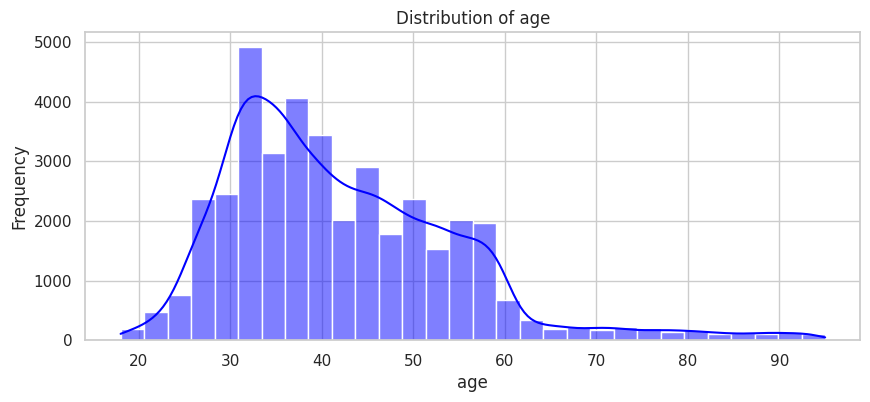

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


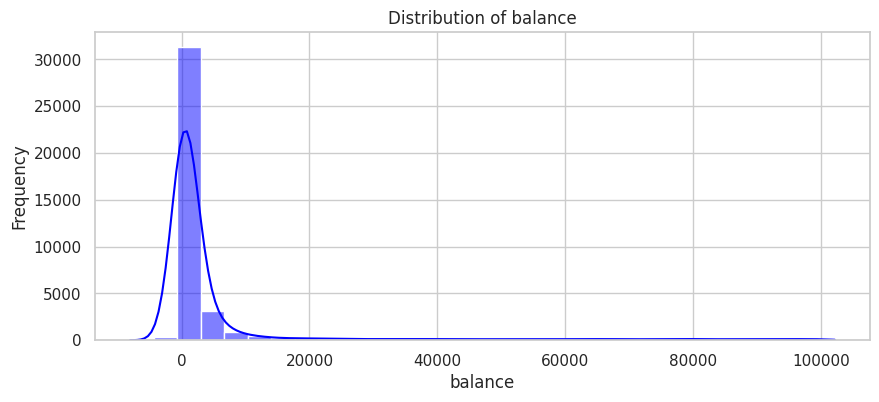

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


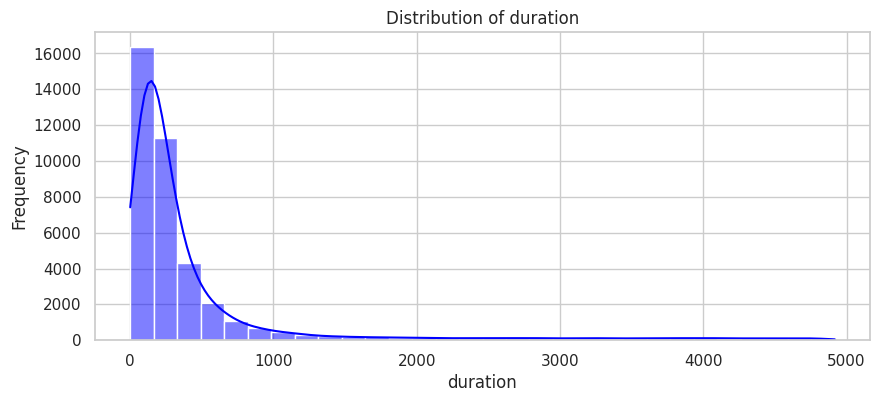

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


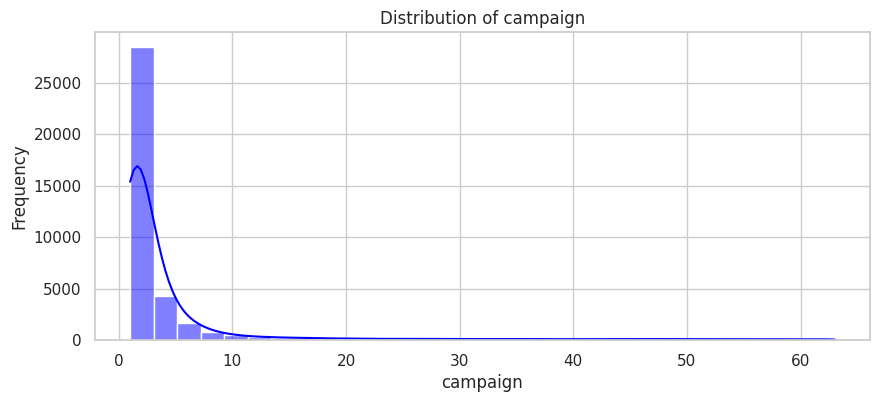

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


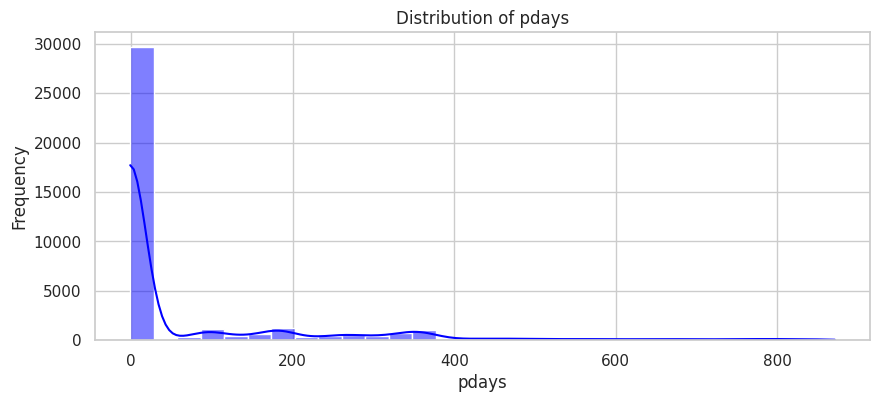

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


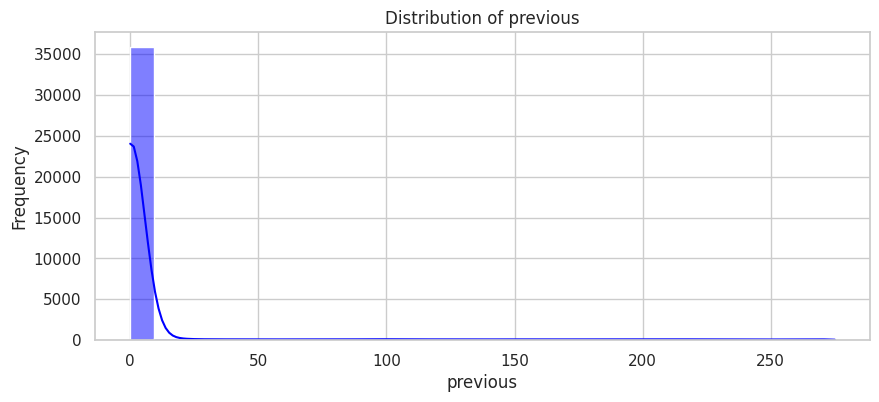

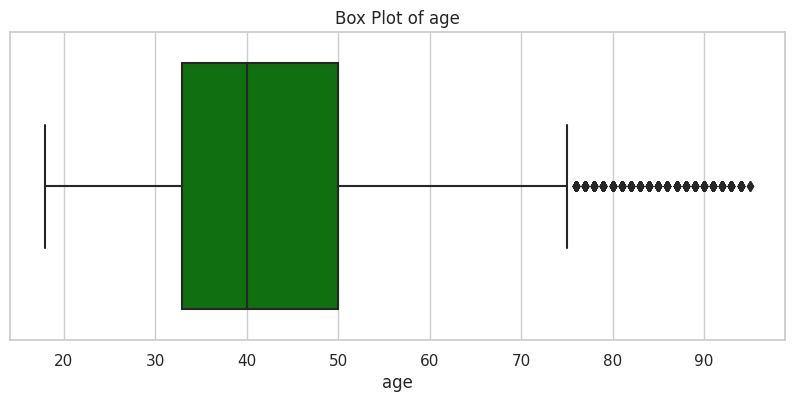

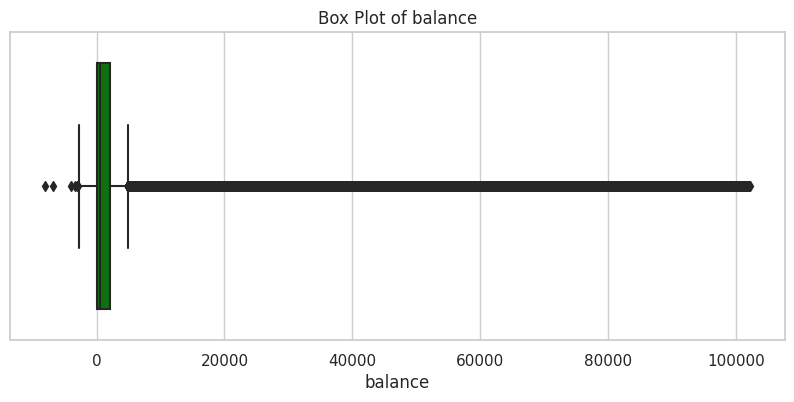

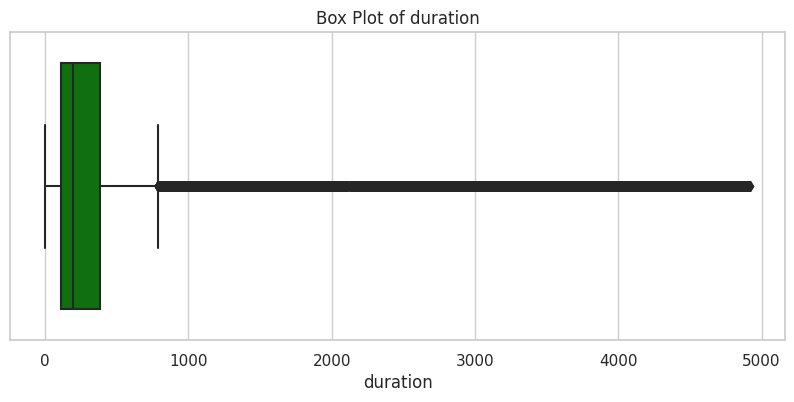

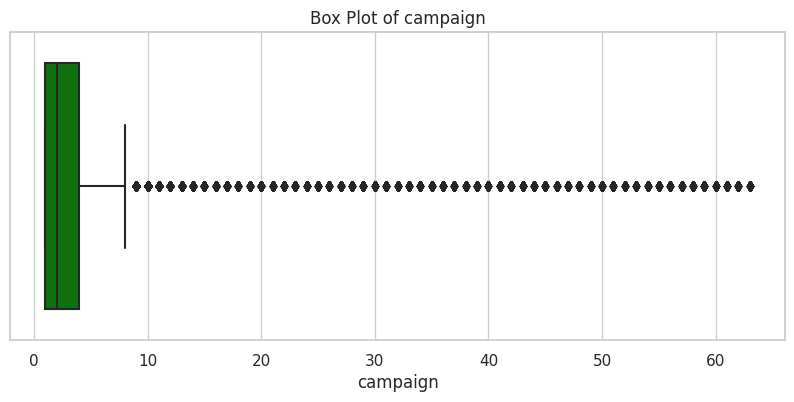

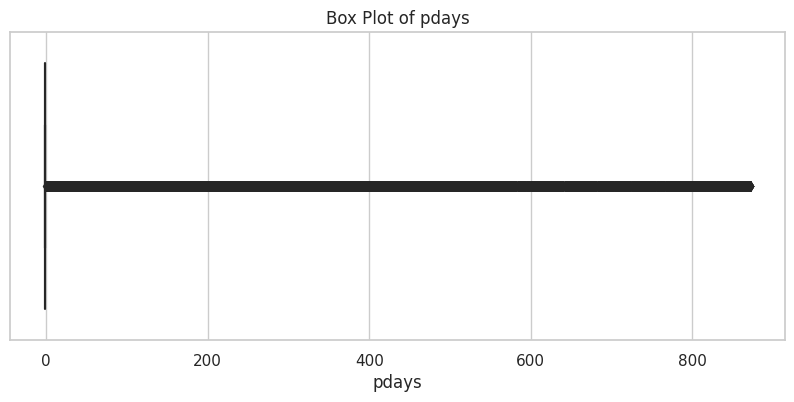

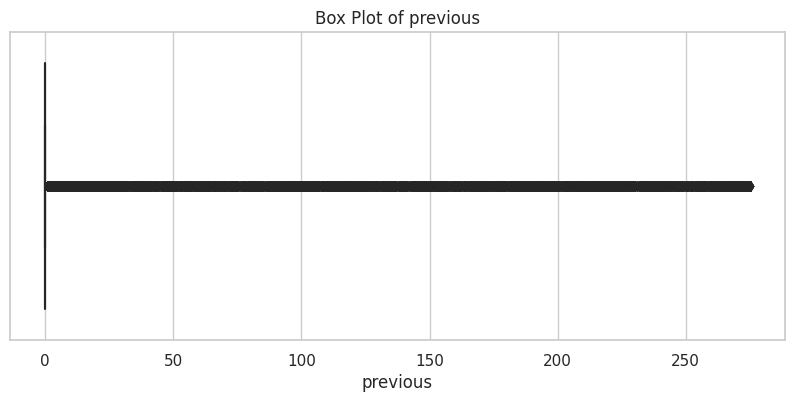

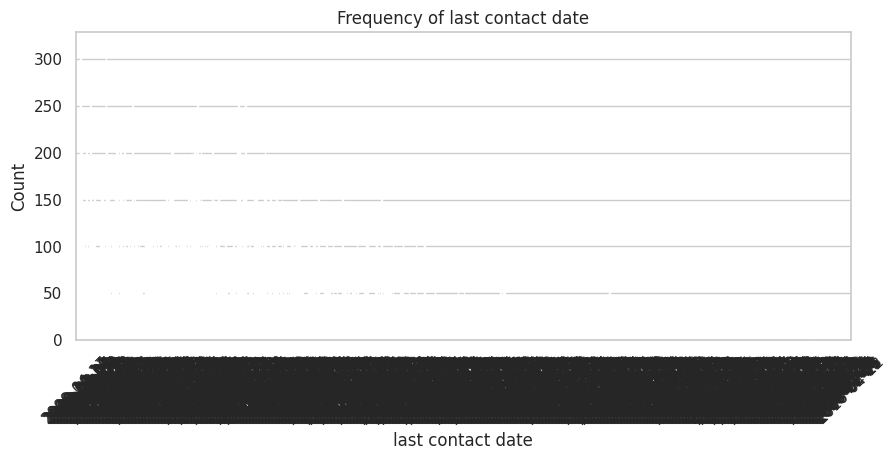

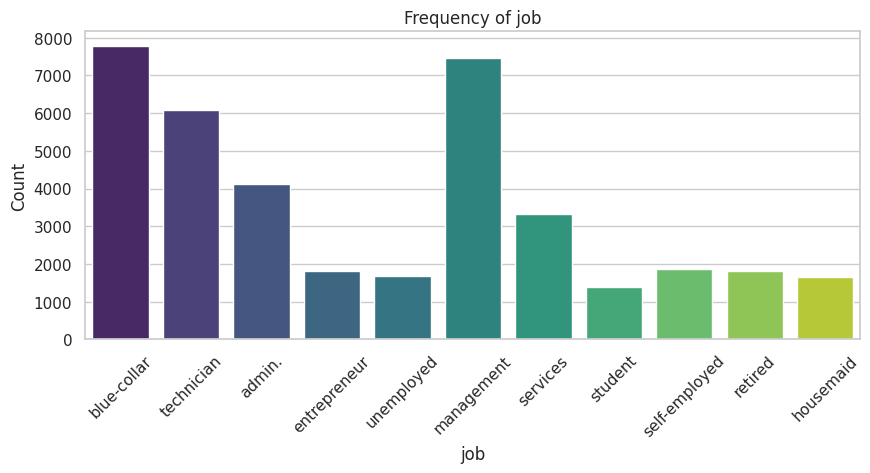

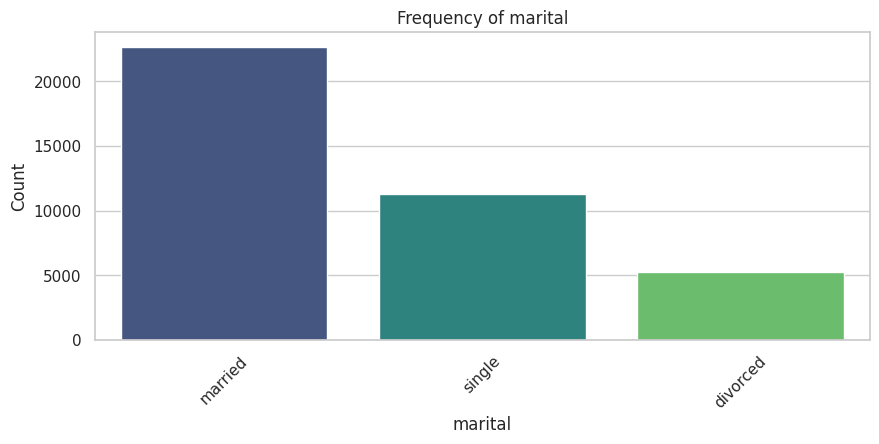

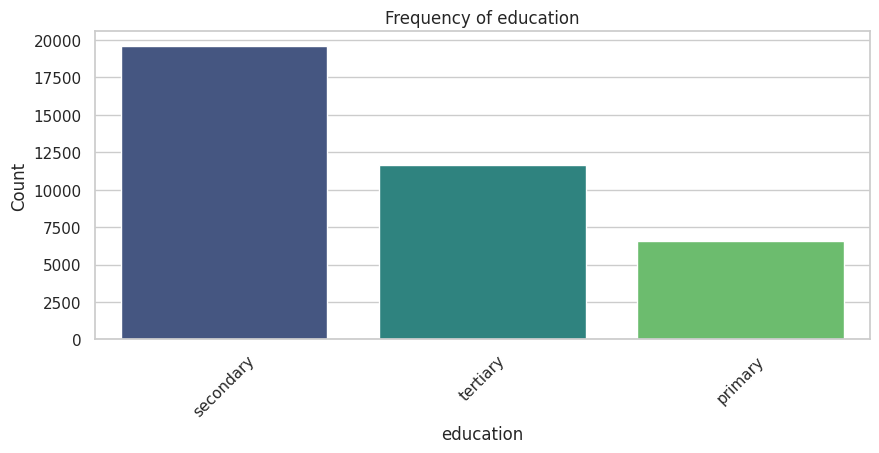

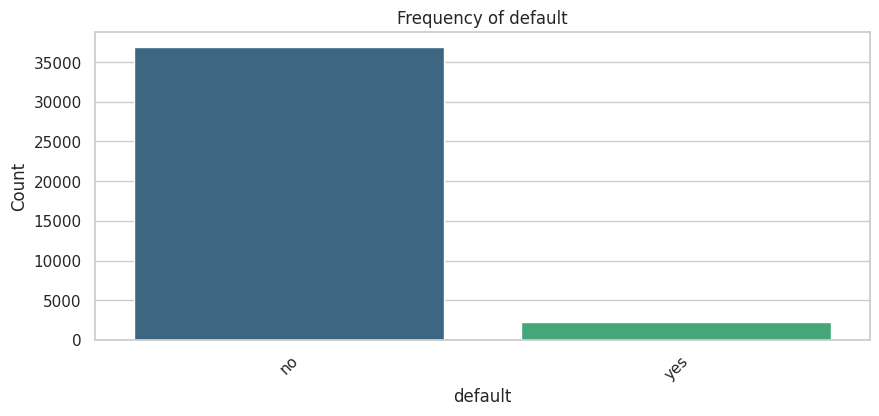

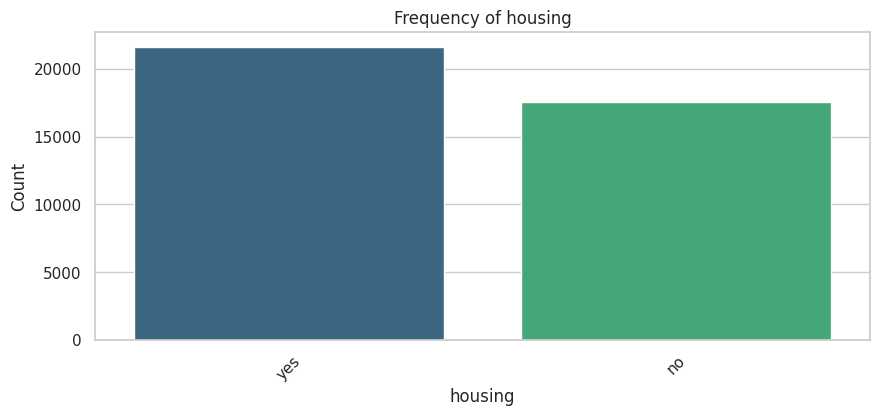

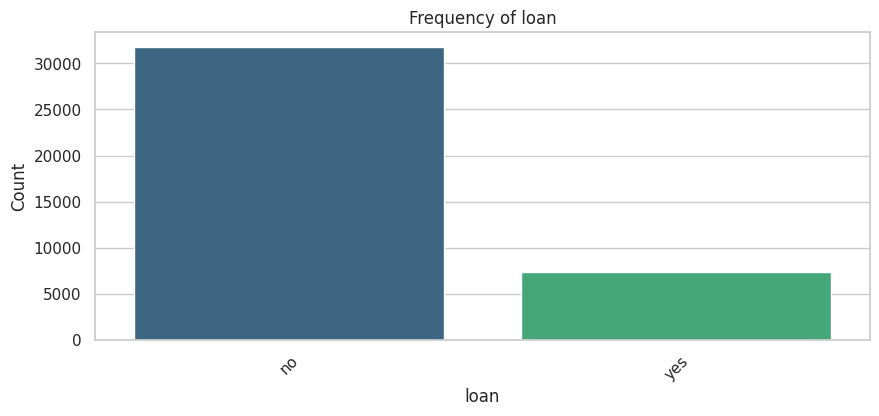

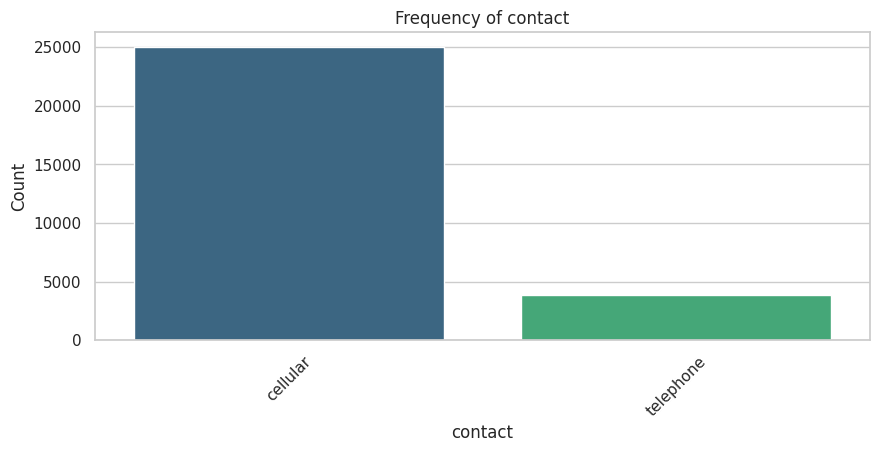

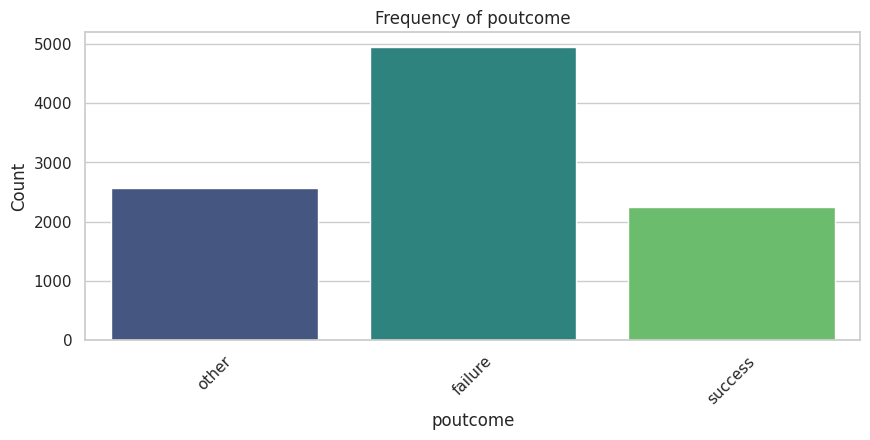

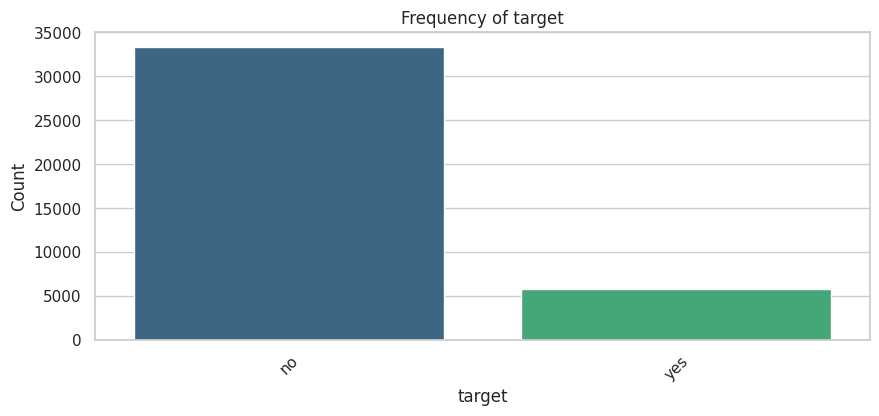

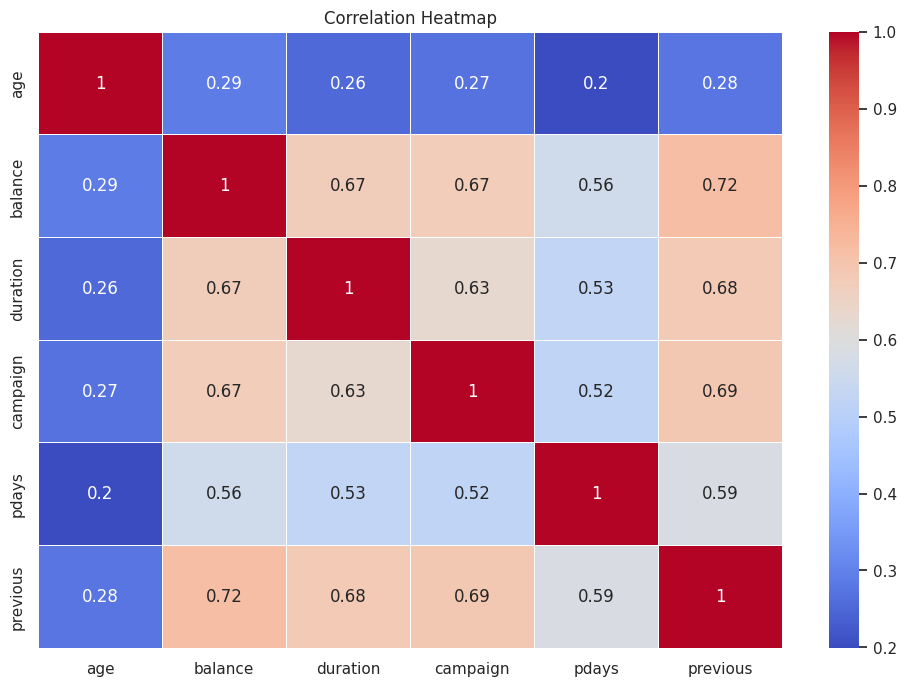

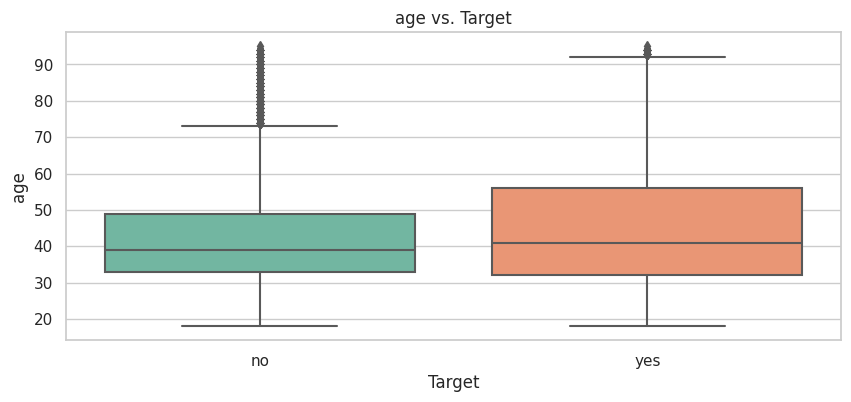

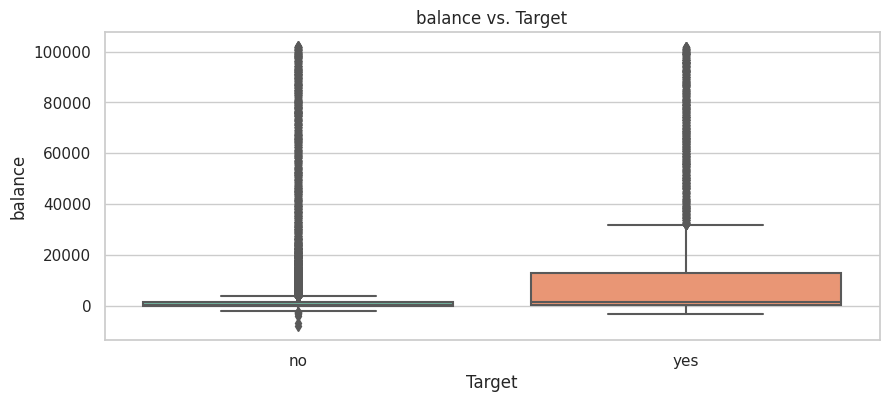

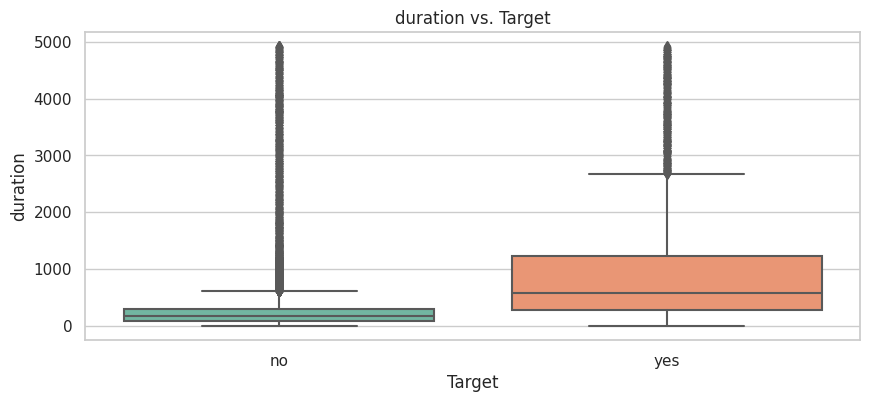

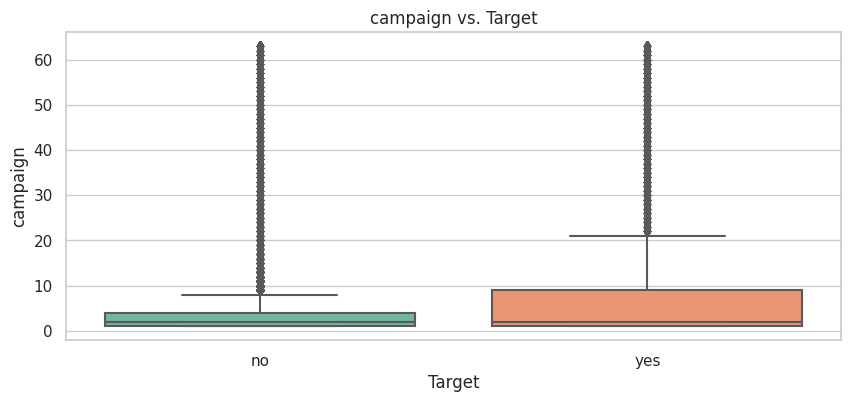

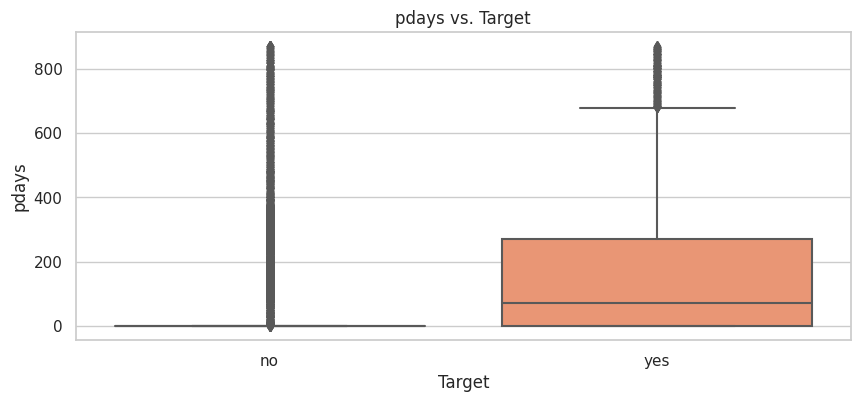

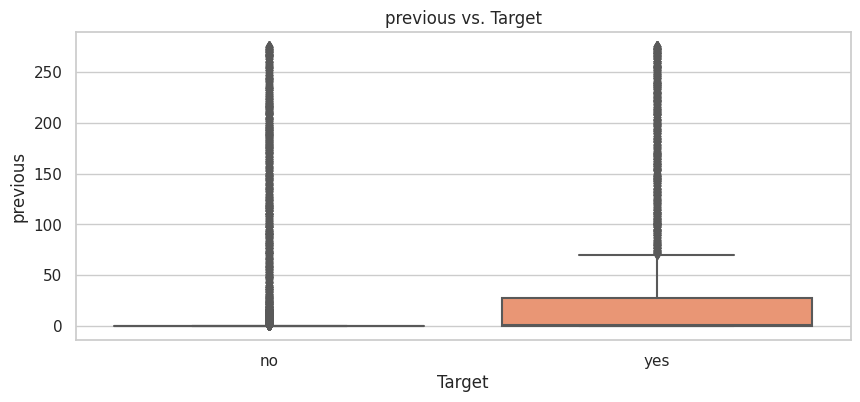

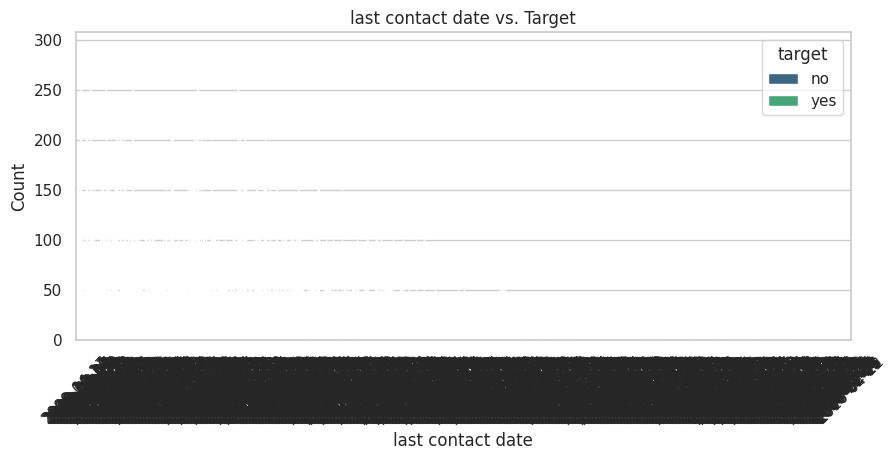

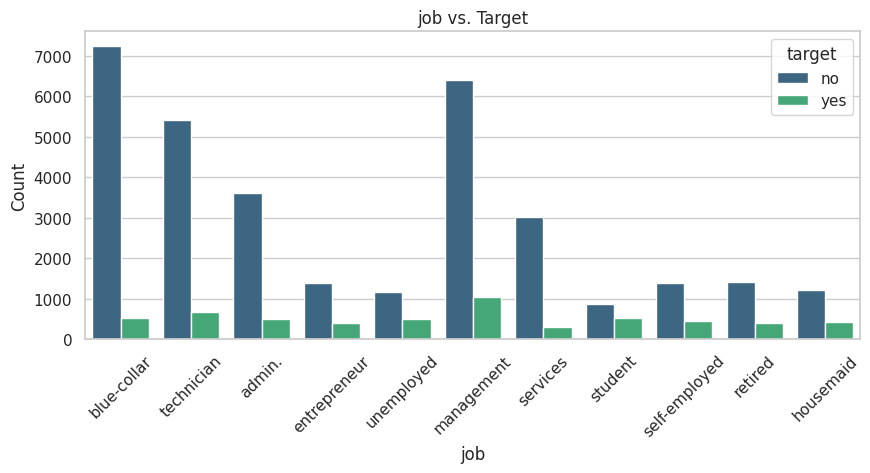

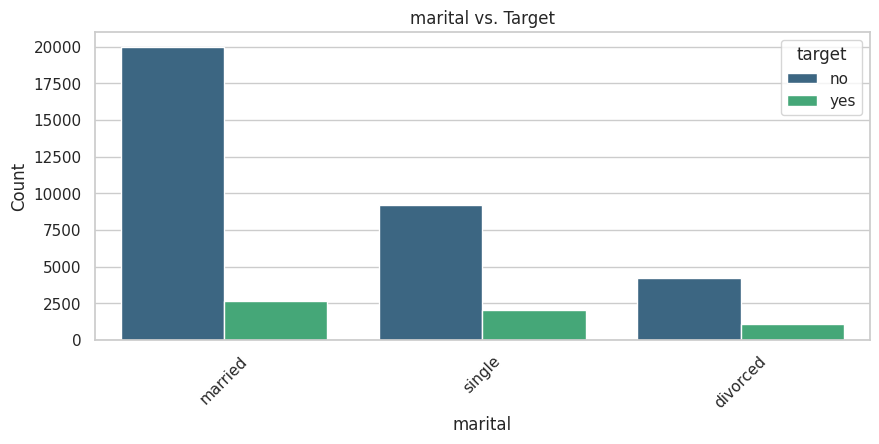

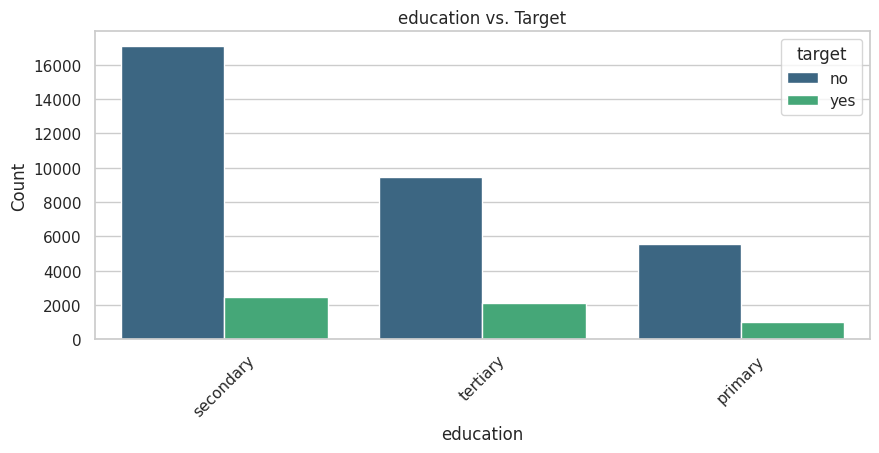

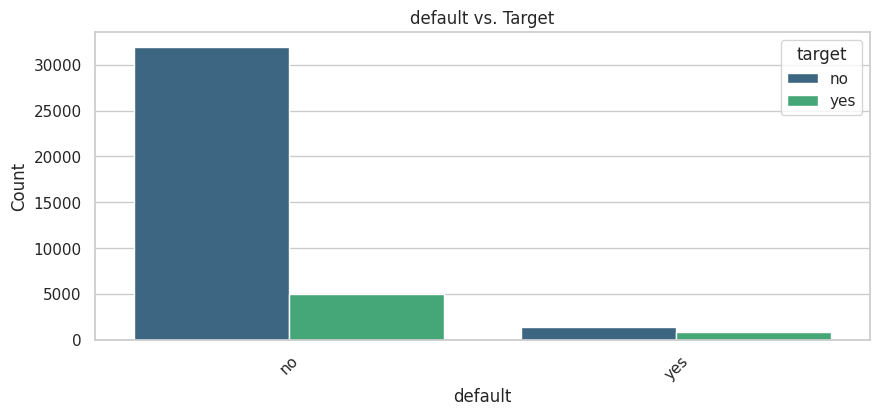

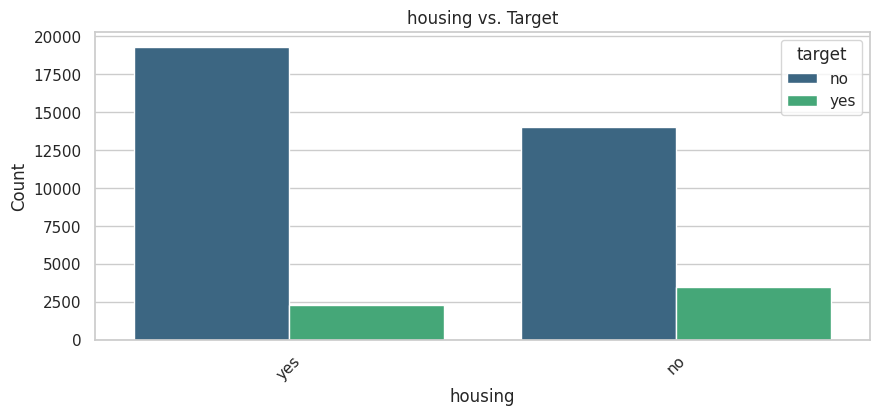

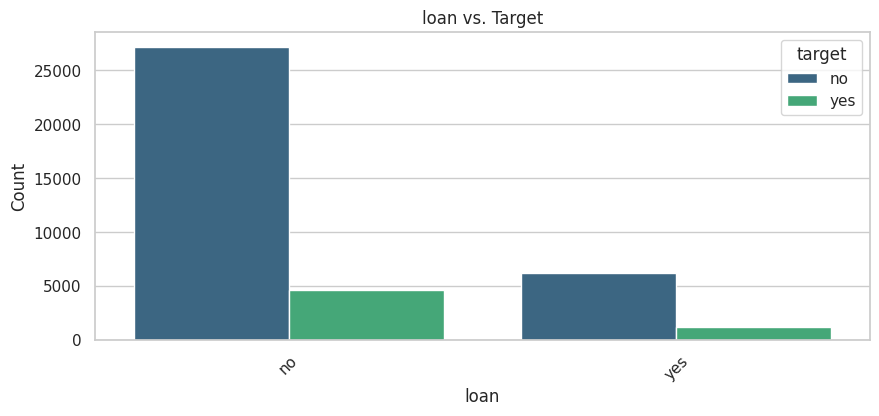

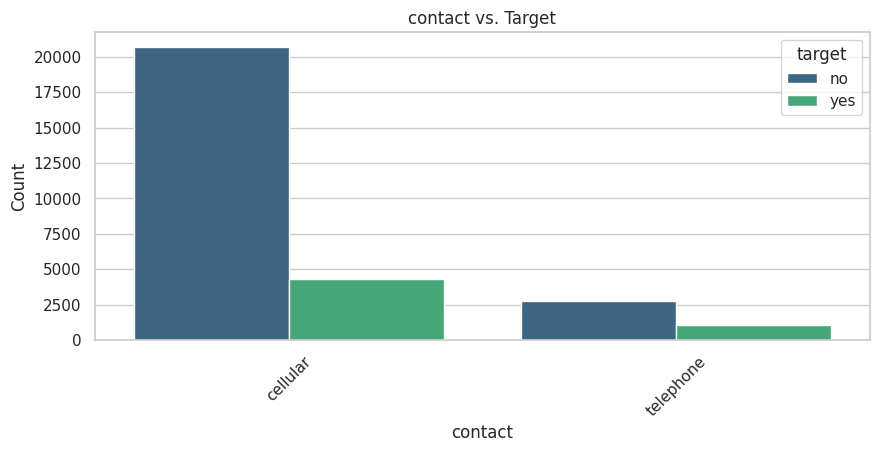

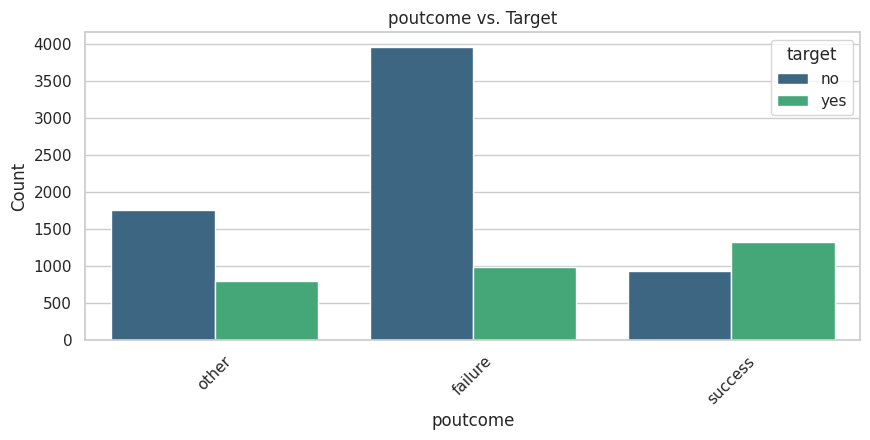

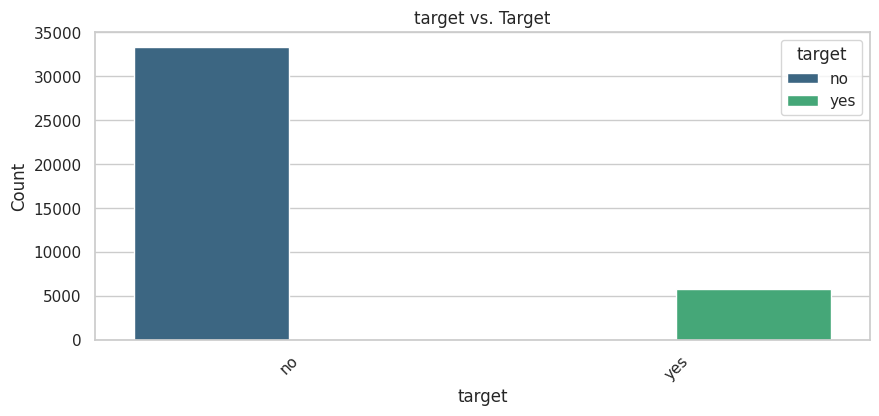


Insights:
1. The feature 'age' is right-skewed, indicating that most customers are younger.
2. Customers with marital status 'married' are more likely to have the target outcome 'yes'.
3. A significant number of missing values exist in 'contact', 'education', and 'poutcome'.


In [6]:
# Visualization - Univariate Analysis
# Histograms and KDE Plots for numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(train[feature], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

# Box Plots for numerical features to detect outliers
for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=train[feature], color='green')
    plt.title(f"Box Plot of {feature}")
    plt.xlabel(feature)
    plt.show()

# Bar Charts for categorical features
for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=train[feature], palette='viridis')
    plt.title(f"Frequency of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))

# Select only numerical columns for correlation matrix
corr_matrix = train.select_dtypes(include=['int64', 'float64']).corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


# Bivariate Analysis
# Numerical Features vs. Target using Box Plots
for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=train['target'], y=train[feature], palette='Set2')
    plt.title(f"{feature} vs. Target")
    plt.xlabel("Target")
    plt.ylabel(feature)
    plt.show()

# Categorical Features vs. Target using Count Plots
for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=feature, hue='target', data=train, palette='viridis')
    plt.title(f"{feature} vs. Target")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

# Documenting Insights
print("\nInsights:")
print("1. The feature 'age' is right-skewed, indicating that most customers are younger.")
print("2. Customers with marital status 'married' are more likely to have the target outcome 'yes'.")
print("3. A significant number of missing values exist in 'contact', 'education', and 'poutcome'.")

In [7]:
train['last contact date'] = pd.to_datetime(train['last contact date'])
train['year'] = train['last contact date'].dt.year
train['month'] = train['last contact date'].dt.month
train['weekday'] = train['last contact date'].dt.weekday
train.drop(columns=['last contact date'], inplace=True)

train = create_fts(train)


X = train.drop(columns=['target', 'year'])
y = (train['target'] == 'yes').astype(int)

In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


num = ['age', 'previous', 'pdays', 'duration', 'balance', 
       'campaign_intensity', 'contact_rate', 'age_balance', 'duration_campaign']
ordinal_cat = ['education']
nominal_cat = ['marital', 'housing', 'loan', 'default', 'weekday', 'contact', 
               'job', 'poutcome', 'age_group', 'balance_group']

In [9]:

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories=[['primary', 'secondary', 'tertiary']]))
])

nominal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', num_pipe, num),
        ('ordinal', ordinal_pipe, ordinal_cat),
        ('nominal', nominal_pipe, nominal_cat)
    ],
    remainder='passthrough'
)

In [10]:

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [11]:
model = XGBClassifier(
    random_state=42,
    scale_pos_weight=3,
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=6,
    n_estimators=300,
    subsample=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    objective='binary:logistic',
    eval_metric='auc',
    early_stopping_rounds=20
)

model.fit(
    X_train_transformed, 
    y_train,
    eval_set=[(X_test_transformed, y_test)],
    verbose=True
)

[0]	validation_0-auc:0.87325
[1]	validation_0-auc:0.88681
[2]	validation_0-auc:0.89161
[3]	validation_0-auc:0.89185
[4]	validation_0-auc:0.89978
[5]	validation_0-auc:0.90015
[6]	validation_0-auc:0.90054
[7]	validation_0-auc:0.90006
[8]	validation_0-auc:0.90029
[9]	validation_0-auc:0.90160
[10]	validation_0-auc:0.90122
[11]	validation_0-auc:0.90236
[12]	validation_0-auc:0.90290
[13]	validation_0-auc:0.90360
[14]	validation_0-auc:0.90370
[15]	validation_0-auc:0.90407
[16]	validation_0-auc:0.90452
[17]	validation_0-auc:0.90470
[18]	validation_0-auc:0.90543
[19]	validation_0-auc:0.90547
[20]	validation_0-auc:0.90551
[21]	validation_0-auc:0.90537
[22]	validation_0-auc:0.90557
[23]	validation_0-auc:0.90560
[24]	validation_0-auc:0.90567
[25]	validation_0-auc:0.90598
[26]	validation_0-auc:0.90603
[27]	validation_0-auc:0.90600
[28]	validation_0-auc:0.90641
[29]	validation_0-auc:0.90632
[30]	validation_0-auc:0.90646
[31]	validation_0-auc:0.90679
[32]	validation_0-auc:0.90727
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [12]:
test['last contact date'] = pd.to_datetime(test['last contact date'])
test['year'] = test['last contact date'].dt.year
test['month'] = test['last contact date'].dt.month
test['weekday'] = test['last contact date'].dt.weekday
test.drop(columns=['last contact date'], inplace=True)
test = create_fts(test)
test = test.drop(columns=['year'])
test_transformed = preprocessor.transform(test)






In [13]:

print("\nTraining Set Results:")
y_pred_train = model.predict(X_train_transformed)
print(classification_report(y_train, y_pred_train))

print("\nTest Set Results:")
y_pred_test = model.predict(X_test_transformed)
print(classification_report(y_test, y_pred_test))


Training Set Results:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     26707
           1       0.55      0.87      0.67      4661

    accuracy                           0.88     31368
   macro avg       0.76      0.87      0.80     31368
weighted avg       0.91      0.88      0.89     31368


Test Set Results:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6677
           1       0.51      0.80      0.63      1166

    accuracy                           0.86      7843
   macro avg       0.74      0.84      0.77      7843
weighted avg       0.90      0.86      0.87      7843



In [14]:

print("\nTraining Set Results:")
y_pred_train = model.predict(X_train_transformed)
print(classification_report(y_train, y_pred_train))

print("\nTest Set Results:")
y_pred_test = model.predict(X_test_transformed)
print(classification_report(y_test, y_pred_test))


Training Set Results:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     26707
           1       0.55      0.87      0.67      4661

    accuracy                           0.88     31368
   macro avg       0.76      0.87      0.80     31368
weighted avg       0.91      0.88      0.89     31368


Test Set Results:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6677
           1       0.51      0.80      0.63      1166

    accuracy                           0.86      7843
   macro avg       0.74      0.84      0.77      7843
weighted avg       0.90      0.86      0.87      7843



In [15]:

test_predictions = model.predict(test_transformed)
test_probabilities = model.predict_proba(test_transformed)

submission = pd.DataFrame({
    'id': test.index,
    'target': ['yes' if pred == 1 else 'no' for pred in test_predictions]
})

print("\nFirst few predictions:")


submission.to_csv('submission.csv', index=False)
submission



First few predictions:


,id,target
0,0,no
1,1,no
2,2,no
3,3,no
4,4,yes
...,...,...
9995,9995,no
9996,9996,yes
9997,9997,yes
9998,9998,no


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
import joblib


In [17]:
logistic_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',  
    solver='liblinear'  
)

logistic_model.fit(X_train_transformed, y_train)


LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [18]:

y_pred_train_lr = logistic_model.predict(X_train_transformed)
print("Logistic Regression - Training Set Results:")
print(classification_report(y_train, y_pred_train_lr))

y_pred_test_lr = logistic_model.predict(X_test_transformed)
print("Logistic Regression - Test Set Results:")
print(classification_report(y_test, y_pred_test_lr))


Logistic Regression - Training Set Results:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     26707
           1       0.45      0.76      0.57      4661

    accuracy                           0.83     31368
   macro avg       0.70      0.80      0.73     31368
weighted avg       0.88      0.83      0.84     31368

Logistic Regression - Test Set Results:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      6677
           1       0.46      0.78      0.58      1166

    accuracy                           0.83      7843
   macro avg       0.71      0.81      0.74      7843
weighted avg       0.88      0.83      0.85      7843



In [19]:

test_predictions_lr = logistic_model.predict(test_transformed)

submission_lr = pd.DataFrame({
    'id': test.index,
    'target': ['yes' if pred == 1 else 'no' for pred in test_predictions_lr]
})

submission_lr.to_csv('submission_lr.csv', index=False)


In [20]:

random_forest_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    class_weight='balanced',
    n_jobs=-1 
)

random_forest_model.fit(X_train_transformed, y_train)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [21]:

y_pred_train_rf = random_forest_model.predict(X_train_transformed)
print("Random Forest - Training Set Results:")
print(classification_report(y_train, y_pred_train_rf))

y_pred_test_rf = random_forest_model.predict(X_test_transformed)
print("Random Forest - Test Set Results:")
print(classification_report(y_test, y_pred_test_rf))


Random Forest - Training Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26707
           1       1.00      1.00      1.00      4661

    accuracy                           1.00     31368
   macro avg       1.00      1.00      1.00     31368
weighted avg       1.00      1.00      1.00     31368

Random Forest - Test Set Results:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93      6677
           1       0.60      0.35      0.44      1166

    accuracy                           0.87      7843
   macro avg       0.75      0.65      0.68      7843
weighted avg       0.85      0.87      0.85      7843



In [22]:

test_predictions_rf = random_forest_model.predict(test_transformed)

submission_rf = pd.DataFrame({
    'id': test.index,
    'target': ['yes' if pred == 1 else 'no' for pred in test_predictions_rf]
})

submission_rf.to_csv('submission_rf.csv', index=False)


In [23]:

model_performance = {
    'Model': [],
    'Train Accuracy': [],
    'Test Accuracy': [],
    'Train F1-Score': [],
    'Test F1-Score': []
}


def compute_metrics(model_name, y_train, y_pred_train, y_test, y_pred_test):
    model_performance['Model'].append(model_name)
    model_performance['Train Accuracy'].append(accuracy_score(y_train, y_pred_train))
    model_performance['Test Accuracy'].append(accuracy_score(y_test, y_pred_test))
    model_performance['Train F1-Score'].append(f1_score(y_train, y_pred_train))
    model_performance['Test F1-Score'].append(f1_score(y_test, y_pred_test))


compute_metrics('Logistic Regression', y_train, y_pred_train_lr, y_test, y_pred_test_lr)


compute_metrics('Random Forest', y_train, y_pred_train_rf, y_test, y_pred_test_rf)


y_pred_train_xgb = model.predict(X_train_transformed)
y_pred_test_xgb = model.predict(X_test_transformed)
compute_metrics('XGBoost', y_train, y_pred_train_xgb, y_test, y_pred_test_xgb)


performance_df = pd.DataFrame(model_performance)
print(performance_df)


                 Model  Train Accuracy  Test Accuracy  Train F1-Score  \
0  Logistic Regression        0.828296       0.832972        0.567875   
1        Random Forest        1.000000       0.868800        1.000000   
2              XGBoost        0.875414       0.858090        0.673681   

   Test F1-Score  
0       0.581470  
1       0.440457  
2       0.627635  


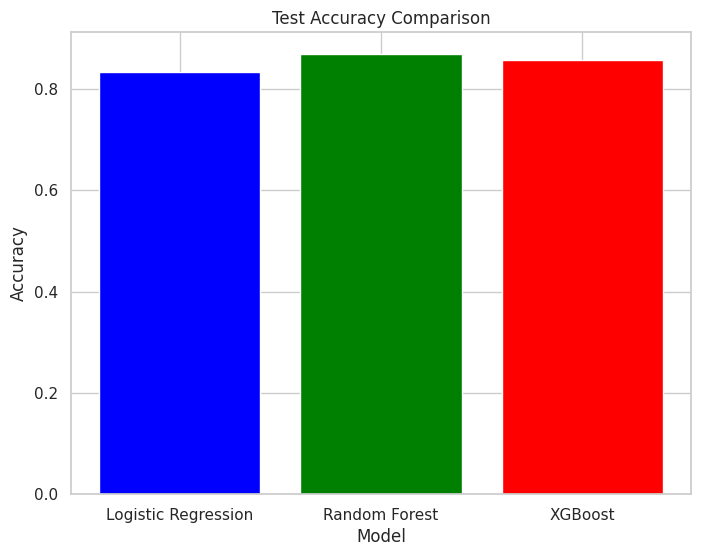

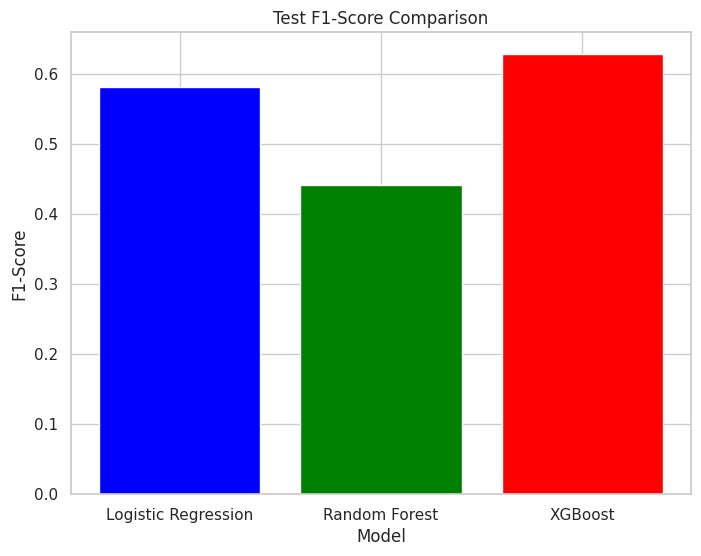

In [24]:

import matplotlib.pyplot as plt

# Plot Test Accuracy
plt.figure(figsize=(8, 6))
plt.bar(performance_df['Model'], performance_df['Test Accuracy'], color=['blue', 'green', 'red'])
plt.title('Test Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# Plot Test F1-Score
plt.figure(figsize=(8, 6))
plt.bar(performance_df['Model'], performance_df['Test F1-Score'], color=['blue', 'green', 'red'])
plt.title('Test F1-Score Comparison')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.show()


In [25]:


final_submission = pd.DataFrame({
    'id': test.index,
    'target': ['yes' if pred == 1 else 'no' for pred in test_predictions_rf]
})

final_submission.to_csv('final_submission.csv', index=False)
